In [1]:
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
from multiprocessing import cpu_count
import numpy as np
import pickle
import time

from games.foraging import Foraging
from agents.jalam_agent import JALAMAgent, JALAMAgentConfig

In [2]:
game_config = [
        "Foraging-5x5-2p-1f-v3",
        "Foraging-7x7-2p-1f-v3",
        "Foraging-7x7-3p-1f-v3",
        "Foraging-7x7-3p-1f-coop-v3",
    ]

In [ ]:
configurations = {
    'jalam_0': {
        'game': game_config[0],
        'jalam': JALAMAgentConfig(
            start_epsilon=1.0, # Epsilom inicial
            min_epsilon=0.01,  # Mínimo valor que puede tomar epsilom
            episodes=2000,     # Cantidad de episodios (debe coincidir con training_config)
            alpha=0.1,         # Taza de aprendizaje
            gamma=0.9,         # Factor de descuento
            exploring=True,    # Variable que determina si se esta en étapa de exploración o no (update y epsilom-greedy o política greedy)
            seed=1             # Semilla para la aleatoriedad
        ),
        'train_config': {
            'episodes': 2000,     # debe coincidir con el config de jalam
            'iterations': 10,
            'min_epsilon_decay': 0.9
        }
    },
    'jalam_1': {
        'game': game_config[1],
        'jalam': JALAMAgentConfig(
            start_epsilon=1.0,
            min_epsilon=0.01,
            episodes=10000,
            alpha=0.1,
            gamma=0.9,
            exploring=True,
            seed=1
        ),
        'train_config': {
            'episodes': 10000,     # debe coincidir con el config de jalam
            'iterations': 10,
            'min_epsilon_decay':  0.9
        }
    },
    'jalam_2': {
        'game': game_config[2],
        'jalam': JALAMAgentConfig(
            start_epsilon=1.0,
            min_epsilon=0.05,
            episodes=10000,
            alpha=0.15,
            gamma=0.9,
            exploring=True,
            seed=1
        ),
        'train_config': {
            'episodes': 10000,     # debe coincidir con el config de jalam
            'iterations': 30,
            'min_epsilon_decay':  0.9
        }
    },
    'jalam_3': {
        'game': game_config[3],
        'jalam': JALAMAgentConfig(
            start_epsilon=1.0,
            min_epsilon=0.05,
            episodes=20000,
            alpha=0.15,
            gamma=0.9,
            exploring=True,
            seed=1
        ),
        'train_config': {
            'episodes': 20000,     # debe coincidir con el config de jalam
            'iterations': 50,
            'min_epsilon_decay':  0.9
        }
    }
}

In [4]:
def play_episode(game, agents, verbose=False, render=False):

    # Initialize the game
    game.reset()
    step_count = 0

    # Initialize each agent
    for agent in game.agents:
        agents[agent].reset()

    # Print initial observations if verbose is enabled
    if verbose:
        print(f"Step: {step_count}")
        for agent in game.agents:
            print(f"Agent {agent} observe: {game.observe(agent)}")

    # Initialize rewards for each agent
    cum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))

    # render the game if required
    if render:
        game.render()
        time.sleep(0.5)

    while not game.done():

        step_count += 1
        
        # Get actions from each agent
        actions = {}
        for agent in game.agents:
            actions[agent] = agents[agent].action()
             
        # Perform the actions in the game
        game.step(actions)

        # Update the cum_rewards for each agent
        for agent in game.agents:
            cum_rewards[agent] += game.reward(agent)

        # Print actions, rewards and next state if verbose is enabled
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                    print(f"Agent {agent} action: {actions[agent]} - {game.action_set[actions[agent]]}")
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.5)
    
        for agent in game.agents:
            # Update the agent with the last observation
            agents[agent].update(actions)
    
    return cum_rewards

In [5]:
def run(game, agents, episodes=1, verbose=False, render=False):
    sum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))
    for _ in range(episodes):
        cum_rewards = play_episode(game, agents, verbose=verbose, render=render)  
        for agent in game.agents:
            sum_rewards[agent] += cum_rewards[agent]
    if verbose:
        print(f"Average rewards over {episodes} episodes:")
        for agent in game.agents:
            print(f"Agent {agent}: {sum_rewards[agent] / episodes}")  
    return sum_rewards     

In [6]:
def train(game, agents, train_config, progress=False, verbose=False, render=False):
    iterations = train_config["iterations"]
    episodes = train_config["episodes"]
    min_epsilon_decay = train_config["min_epsilon_decay"]
    average_rewards = dict(map(lambda agent: (agent, []), game.agents))
    epsilons = [agent.epsilon for agent in agents.values()]
    for i in range(1, iterations+1):
        for i, agent in enumerate(agents.values()):
            agent.epsilon = epsilons[i] * (min_epsilon_decay ** i)
        sum_rewards = run(game, agents, episodes=episodes, verbose=verbose, render=render)
        for agent in game.agents:
            average_rewards[agent].append(sum_rewards[agent] / episodes)
        if progress and (i % 10 == 0):
            print(f"Iteration {i} ({i * episodes} episodes) (start_epsilon: {epsilons[i] * (min_epsilon_decay ** i)})")
            for agent in game.agents:
                print(f"Agent {agent}: {average_rewards[agent][-1]}")
    if progress:
        print(f"Last average rewards over {iterations} iterations ({iterations * episodes} episodes):")
        for agent in game.agents:
            print(f"Agent {agent}: {average_rewards[agent][-1]}")
    return average_rewards

In [7]:
def entrenar_agente_tarea(args):
    config_id, config = args
    game = Foraging(config=config['game'], seed=1)
    agents = dict(map(lambda agent: (agent, JALAMAgent(game=game, agent=agent, config=config['jalam'], action_spaces=game.action_spaces)), game.agents))

    game.reset()
    for agent in game.agents:
        print(f"Agent: {agent}")
        print(f"Observation: {game.observe(agent)}")

    average_rewards = train(game, agents, train_config=config['train_config'], progress=True, verbose=False, render=False)

    resultados_dict = {
        f"experimento_{config_id}": {
            'agents': agents,
            'game': game,
            'config': config,
            'average_rewards': average_rewards
        }
    }

    with open(f"experiments/results_{config_id}.pkl", "wb") as f:
        pickle.dump(resultados_dict, f)

    return resultados_dict

In [8]:
# Armar lista de tareas: cada elemento es una tupla (config_id, config)
tareas = [(config_id, config) for config_id, config in configurations.items()]

# Número de procesos (podés limitarlo si querés)
n_proc = min(len(tareas), cpu_count())

In [ ]:
with ThreadPool(n_proc) as pool:
    resultados = pool.map(entrenar_agente_tarea, tareas)

Agent: agent_0
Observation: [5. 2. 2. 3. 5. 2. 0. 1. 2.]
Agent: agent_1
Observation: [5. 2. 2. 0. 1. 2. 3. 5. 2.]
Agent: agent_0
Observation: [5. 2. 4. 0. 1. 2. 6. 1. 1. 6. 2. 1.]
Agent: agent_1
Observation: [5. 2. 4. 6. 1. 1. 0. 1. 2. 6. 2. 1.]
Agent: agent_2
Observation: [5. 2. 4. 6. 2. 1. 0. 1. 2. 6. 1. 1.]
Agent: agent_0
Observation: [5. 2. 2. 0. 1. 2. 6. 1. 1. 6. 2. 1.]
Agent: agent_1
Observation: [5. 2. 2. 6. 1. 1. 0. 1. 2. 6. 2. 1.]
Agent: agent_2
Observation: [5. 2. 2. 6. 2. 1. 0. 1. 2. 6. 1. 1.]


c:\Users\Guillermo\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(
c:\Users\Guillermo\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Agent: agent_0
Observation: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent: agent_1
Observation: [3. 1. 2. 0. 0. 2. 2. 3. 2.]
Last average rewards over 10 iterations (20000 episodes):
Agent agent_0: 0.44075
Agent agent_1: 0.45625


In [ ]:
import os

experiments_names = ['Foraging-5x5-2p-1f-v3__results_jalam-0.pkl', 'Foraging-8x8-2p-1f-v3__results_jalam-1.pkl', 'Foraging-8x8-3p-1f-v3__results_jalam-2.pkl', 'Foraging-8x8-3p-1f-coop-v3__results_jalam-3.pkl']

experiments = {}
for exp_name in experiments_names:
    print(exp_name)
    path = f"./experiments/{exp_name}"
    if os.path.exists(path):
        with open(path, "rb") as f:
            experiment = pickle.load(f)
            for key, val in experiment.items():
                experiments[key] = val

Foraging-5x5-2p-1f-v3__results_jalam-0.pkl
Foraging-8x8-2p-1f-v3__results_jalam-1.pkl
Foraging-8x8-3p-1f-v3__results_jalam-2.pkl
Foraging-8x8-3p-1f-coop-v3__results_jalam-3.pkl


Experiment config: Foraging-5x5-2p-1f-v3


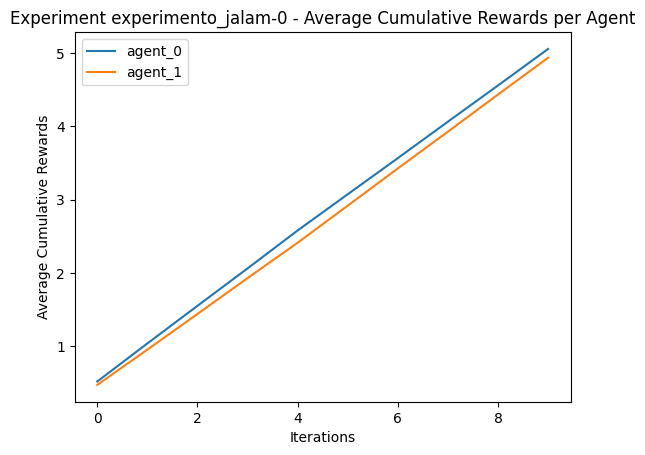

Experiment config: Foraging-8x8-2p-1f-v3


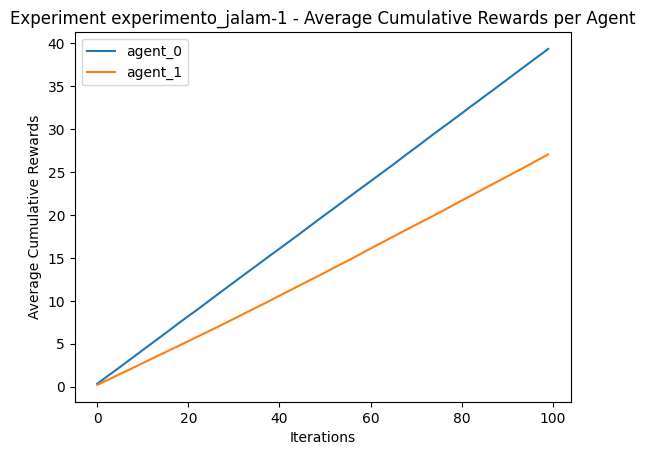

Experiment config: Foraging-8x8-3p-1f-v3


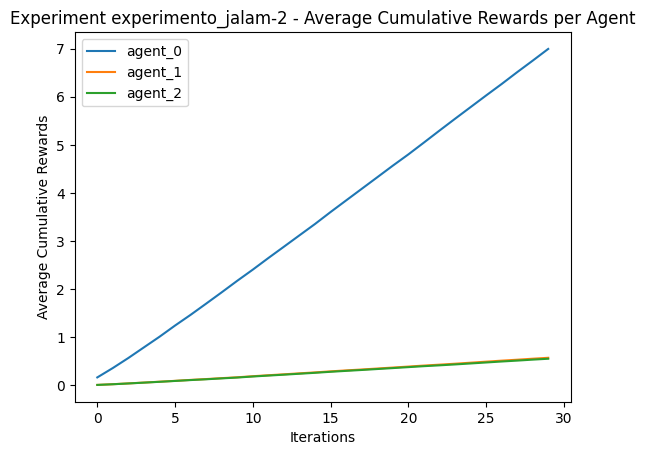

Experiment config: Foraging-8x8-3p-1f-coop-v3


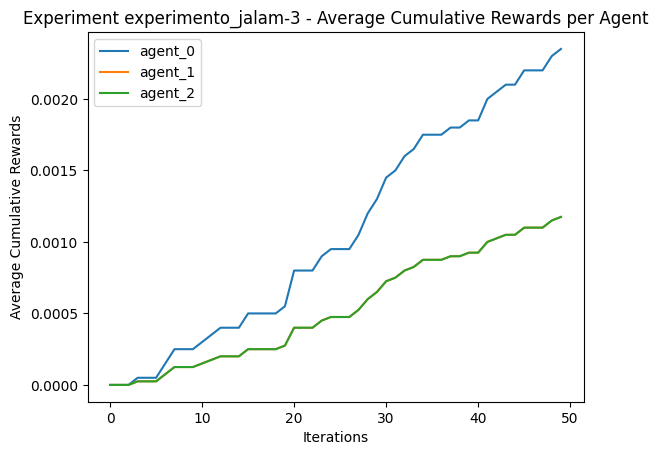

: 

In [ ]:
for experiment_name, experiment in experiments.items():

    print(f"Experiment config: {experiment['config']['game']}")

    average_rewards = experiment['average_rewards']

    for agent, rewards in average_rewards.items():
        plt.plot(np.cumsum(rewards), label=agent)

    plt.xlabel('Iterations')
    plt.ylabel('Average Cumulative Rewards')
    plt.title(f'Experiment {experiment_name} - Average Cumulative Rewards per Agent')
    plt.legend()
    plt.show()

    experiment_agents = experiment['agents']
    for agent in experiment_agents.keys():
        experiment_agents[agent].exploring = False

    game = experiment['game']

    play_episode(game, experiment_agents, verbose=False, render=True)
    game.reset()